# Loading lib and data

In [ ]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [38]:
# Loading all the data from dataset
import pandas as pd
import numpy as np
# ===== Dataset Notes =====
# ```
# Ver 6 logmel-mfcc-set = MFCC 13, LOGMEL 128, Group_Delay, Wav2Vec2
# Ver 5 logmel-mfcc-set = MFCC 40 with augmentation
# Ver 4 logmel-mfcc-set = MFCC 40
# Ver 1 logmel-mfcc-set = MFCC & Logmel 13
#
# CURRENTLY IN: Version 1
# ```


# DATA_PATH = '/kaggle/input/logmel-mfcc-set/'
# DATA_PATH = '/kaggle/input/mfcc-wo-swf/'
DATA_PATH = '/kaggle/input/mfcc13-wo-swf/'
# DATA_PATH = '/kaggle/input/mfcc-no-filtering/'

# =========== MFCC ===========
# X_train_mfcc = pd.read_pickle(DATA_PATH + 'X_train_mfcc.pkl')
# X_dev_mfcc = pd.read_pickle(DATA_PATH + 'X_dev_mfcc.pkl')
# X_eval_mfcc = pd.read_pickle(DATA_PATH + 'X_eval_mfcc.pkl')

# y_train_mfcc = pd.read_pickle(DATA_PATH + 'y_train_mfcc.pkl')
# y_dev_mfcc = pd.read_pickle(DATA_PATH + 'y_dev_mfcc.pkl')
# y_eval_mfcc = pd.read_pickle(DATA_PATH + 'y_eval_mfcc.pkl')

# ============================ SEPARATOR mfcc no filtering ============================
n_mfcc = 13 # 40 atau 13
filters = 'wf'  # 'sf', 'wf', or 'swf'

# Construct file names dynamically
file_suffix = f"_wo_{filters}_{n_mfcc}.pkl"

# X_train_mfcc = pd.read_pickle(DATA_PATH + f'X_train_mfcc{file_suffix}')
# X_dev_mfcc = pd.read_pickle(DATA_PATH + f'X_dev_mfcc{file_suffix}')
# X_eval_mfcc = pd.read_pickle(DATA_PATH + f'X_eval_mfcc{file_suffix}')

# y_train_mfcc = pd.read_pickle(DATA_PATH + f'y_train_mfcc{file_suffix}')
# y_dev_mfcc = pd.read_pickle(DATA_PATH + f'y_dev_mfcc{file_suffix}')
# y_eval_mfcc = pd.read_pickle(DATA_PATH + f'y_eval_mfcc{file_suffix}')

# ============================ SEPARATOR mfcc 40 no filtering ============================

# X_train_mfcc = pd.read_pickle(DATA_PATH + 'X_train_mfcc_wo_swf.pkl')
# X_dev_mfcc = pd.read_pickle(DATA_PATH + 'X_dev_mfcc_wo_swf.pkl')
# X_eval_mfcc = pd.read_pickle(DATA_PATH + 'X_eval_mfcc_wo_swf.pkl')

# y_train_mfcc = pd.read_pickle(DATA_PATH + 'y_train_mfcc_wo_swf.pkl')
# y_dev_mfcc = pd.read_pickle(DATA_PATH + 'y_dev_mfcc_wo_swf.pkl')
# y_eval_mfcc = pd.read_pickle(DATA_PATH + 'y_eval_mfcc_wo_swf.pkl')

# ============================ SEPARATOR mfcc 13 no filtering ============================

X_train_mfcc = pd.read_pickle(DATA_PATH + 'X_train_mfcc_wo_swf_13.pkl')
X_dev_mfcc = pd.read_pickle(DATA_PATH + 'X_dev_mfcc_wo_swf_13.pkl')
X_eval_mfcc = pd.read_pickle(DATA_PATH + 'X_eval_mfcc_wo_swf_13.pkl')

y_train_mfcc = pd.read_pickle(DATA_PATH + 'y_train_mfcc_wo_swf_13.pkl')
y_dev_mfcc = pd.read_pickle(DATA_PATH + 'y_dev_mfcc_wo_swf_13.pkl')
y_eval_mfcc = pd.read_pickle(DATA_PATH + 'y_eval_mfcc_wo_swf_13.pkl')

In [39]:
X_train_mfcc = X_train_mfcc.astype('float32')
y_train_mfcc = y_train_mfcc.astype('float32')
X_dev_mfcc = X_dev_mfcc.astype('float32')
y_dev_mfcc = y_dev_mfcc.astype('float32')
X_eval_mfcc = X_eval_mfcc.astype('float32')
y_eval_mfcc = y_eval_mfcc.astype('float32')

## EER Calculation

In [2]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
def eval_metr(y_true, y_pred, C0, C1, P_target=0.5):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate (Miss Rate)

    # Compute EER
    abs_diff = np.abs(fpr - fnr)
    eer_index = np.argmin(abs_diff)
    eer = (fpr[eer_index] + fnr[eer_index]) / 2

    # Compute t-DCF
    pi_spoof = P_target  # Prior for spoof
    pi_bonafide = 1 - P_target  # Prior for bonafide

    # Calculate t-DCF values
    tdcf_values = (pi_bonafide * C0 * fnr + pi_spoof * C1 * fpr) / min(pi_bonafide * C0, pi_spoof * C1)

    # Find minimum t-DCF
    min_tdcf = np.min(tdcf_values)

    return eer, min_tdcf

# Initializing CNN, Training, and Evaluating

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def build_model(input_shape=(298, 13, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First Time-Distributed 2D Convolution
    x = layers.Conv2D(36, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    
    # Second Time-Distributed 2D Convolution
    x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
    
    # Third Time-Distributed 2D Convolution + MaxPooling
    x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    
    # First Dense Layer
    x = layers.Dense(24, activation='relu')(x)
    
    # Second Dense Layer
    x = layers.Dense(24, activation='relu')(x)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    
    # Final Dense Layer (Output)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

def cnn_maker(X_train, y_train, X_dev, y_dev, X_eval, y_eval):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    ### Merging for splitting purposes ###
    
    # # Merge all datasets
    # X_all = np.concatenate([X_train, X_dev, X_eval], axis=0)
    # y_all = np.concatenate([y_train, y_dev, y_eval], axis=0)
    
    # # Shuffle and split into 70-15-15
    # X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.30, random_state=seed, shuffle=True)
    # X_dev, X_eval, y_dev, y_eval = train_test_split(X_temp, y_temp, test_size=0.50, random_state=seed, shuffle=True)

    ### ^ ^ ^ Comment if unused ^ ^ ^ ###
    
    # Add channel axis to the data
    X_train = X_train[..., np.newaxis]
    X_dev = X_dev[..., np.newaxis]
    X_eval = X_eval[..., np.newaxis]

    model = build_model(X_train.shape[1:])
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()
    print("\n")

    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)
    # model_checkpoint = ModelCheckpoint('cnn_base_stft_1.keras', monitor='val_loss', save_best_only=True, verbose=1)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),
                        callbacks=[early_stopping])

    # Evaluate the model on dev data
    dev_loss, dev_accuracy = model.evaluate(X_dev, y_dev, verbose=0)
    print("CNN Model - Dev Accuracy:", dev_accuracy)
        
    # Evaluate the model on evaluation data
    eval_accuracy = model.evaluate(X_eval, y_eval, verbose=0)[1]
    print("CNN Model - Eval Accuracy:", eval_accuracy)

    return model, history

def plot_training_history(history):
    """Function to plot training and validation loss/accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()

In [40]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
del cnn_mfcc_model
cnn_mfcc_model, history = cnn_maker(X_train_mfcc, y_train_mfcc, X_dev_mfcc, y_dev_mfcc, X_eval_mfcc, y_eval_mfcc)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 13, 100, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 13, 100, 36)         │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 13, 100, 64)         │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 13, 100, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 13, 50, 24)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 13, 50, 24)          │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 15600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │          15,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,849 (296.29 KB)

 Trainable params: 75,849 (296.29 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9513 - loss: 0.1392 - val_accuracy: 0.9947 - val_loss: 0.0193
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 0.9977 - val_loss: 0.0089
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9983 - loss: 0.0085 - val_accuracy: 0.9981 - val_loss: 0.0082
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9987 - loss: 0.0061 - val_accuracy: 0.9977 - val_loss: 0.0087
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9969 - val_loss: 0.0115
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9981 - val_loss: 0.0070
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.9978 - val_loss: 0.0075
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9997 - loss: 0.0013 - val_ac

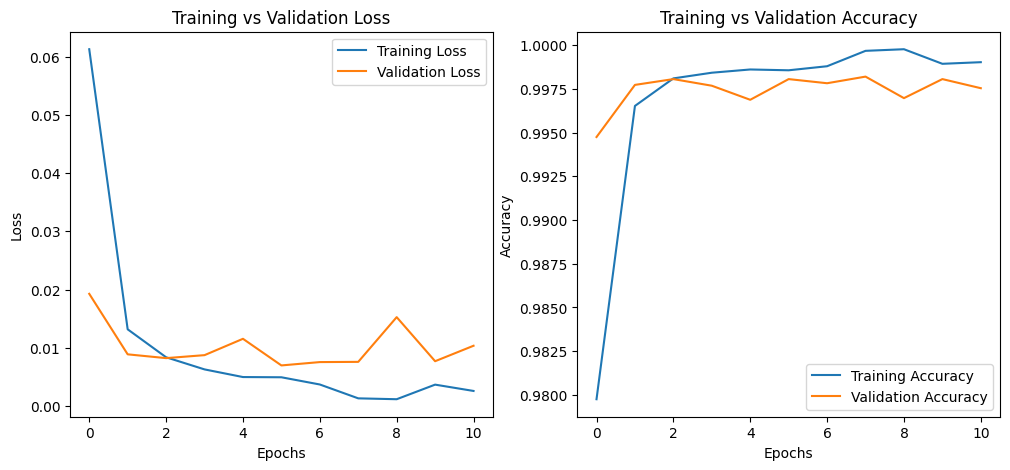

In [41]:
plot_training_history(history)

In [24]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Evaluate the model and get the predicted probabilities
y_pred_dev = cnn_mfcc_model.predict(X_dev_mfcc)  # Get the predicted probabilities for eval data
y_pred_dev_probs_cnn_mfcc = y_pred_dev[:, 0]  # Probability for the positive class (class 1)

roc_auc = roc_auc_score(y_dev_mfcc, y_pred_dev_probs_cnn_mfcc)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_dev_mfcc, (y_pred_dev_probs_cnn_mfcc >= 0.5).astype(int)))

# Evaluate the metrics using eval_metr
# Set cost parameters
C0 = 0.1588  # Cost of a missed detection
C1 = 2.1007  # Cost of a false alarm
eer_cnn_mfcc_dev, min_tdcf_cnn_mfcc_dev = eval_metr(y_dev_mfcc, y_pred_dev_probs_cnn_mfcc, C0, C1)

# Print the results
print(f"CNN EER on validation data: {eer_cnn_mfcc_dev * 100:.2f}%")
print(f"CNN Min t-DCF on validation data: {min_tdcf_cnn_mfcc_dev:.4f}")

661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
ROC AUC: 0.9997071089759081
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18580
         1.0       0.99      0.99      0.99      2548

    accuracy                           1.00     21128
   macro avg       1.00      0.99      0.99     21128
weighted avg       1.00      1.00      1.00     21128

CNN EER on validation data: 0.35%
CNN Min t-DCF on validation data: 0.0199


In [25]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Evaluate the model and get the predicted probabilities
y_pred_eval = cnn_mfcc_model.predict(X_eval_mfcc)  # Get the predicted probabilities for eval data
y_pred_eval_probs_cnn_mfcc = y_pred_eval[:, 0]  # Probability for the positive class (class 1)

roc_auc = roc_auc_score(y_eval_mfcc, y_pred_eval_probs_cnn_mfcc)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_eval_mfcc, (y_pred_eval_probs_cnn_mfcc >= 0.5).astype(int)))

# Evaluate the metrics using eval_metr
# Set cost parameters
C0 = 0.1847  # Cost of a missed detection
C1 = 2.0173  # Cost of a false alarm
eer_cnn_mfcc_eval, min_tdcf_cnn_mfcc_eval = eval_metr(y_eval_mfcc, y_pred_eval_probs_cnn_mfcc, C0, C1)

# Print the results
print(f"CNN EER on testing data: {eer_cnn_mfcc_eval * 100:.2f}%")
print(f"CNN Min t-DCF on testing data: {min_tdcf_cnn_mfcc_eval:.4f}")

1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
ROC AUC: 0.9773073566411432
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     54054
         1.0       0.59      0.98      0.74      7355

    accuracy                           0.92     61409
   macro avg       0.79      0.94      0.84     61409
weighted avg       0.95      0.92      0.92     61409

CNN EER on testing data: 6.99%
CNN Min t-DCF on testing data: 0.5955
